![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

#🔎 Training Financial NER

In [ ]:
from johnsnowlabs import nlp, finance, viz


In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

##📌 Training a custom NerModel

📚The model was trained in the available [Tweets dataset](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020), with data from 2015 to 2020. 

If your appliation needs different entities than the provided pretrained models can identify, what you can do is to train a new model that fits your requirements. To do that you first need to collect and label enough data and put them in the CoNLL 2003 format. If you are not sure how to annotate (label) text data and prepare it in the CoNLL 2003 format, try our free tool [Annotation Lab](https://nlp.johnsnowlabs.com/docs/en/alab/quickstart), where you can easily label text data and export in the correct format for training.

For our purposes here, we will use a sample file annotated by our team.

###✔️ CoNLL Data Prep

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/conll_noO.conll
dbutils.fs.cp("file:/databricks/driver/conll_noO.conll", "dbfs:/") 

Out[5]: True

In [ ]:
with open("./conll_noO.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

( NN NN O
d NN NN O
) NN NN O
OF NN NN O
THE NN NN O
SECURITIES NN NN O
EXCHANGE NN NN O
ACT NN NN O
OF NN NN O
1934 NN NN O
For NN NN O
the NN NN O
annual NN NN O
period NN NN O
ended NN NN O
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
☐ NN NN O
TRANSITION NN NN O
REPORT NN NN O
UNDER NN NN O
SECTION NN NN O
13 NN NN O
OR NN NN O
15

The pipeline is similar to the `NerModel` one, but instead of a `AnnotatorModel`, we use an `AnnotatorApproach` object to train the model. If these concepts of annotator and model is not familiar to you, please review the documentation [here](https://nlp.johnsnowlabs.com/docs/en/concepts).

To load the data into spark dataframe, you can use the [CoNLL](https://nlp.johnsnowlabs.com/docs/en/training#conll-dataset) helper.

In [ ]:
from sparknlp.training import CoNLL

finance_data = CoNLL().readDataset(spark, "file:/dbfs/conll_noO.conll")
finance_data.selectExpr(
    "text", "token.result as tokens", "pos.result as pos", "label.result as label"
).show(3, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
text |tokens |pos |label |
+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
( d ) OF THE SECURITIES EXCHANGE ACT OF 1934 For the annual period ended March 31 , 2021 March 31 , 2021 ☐ TRANSITION REPORT UNDER SECTION 13 OR 15|[(, d, ), OF, THE, SECURITIES, EXCHANGE, ACT, OF, 1934, For, the, annual, period, ended, March, 31, ,, 2021, March, 31, ,, 2021, ☐, TRANSITION, REPORT, UNDER, SECTION, 13, OR, 15]|[NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NN, NN, NN, NN, NN, NN, NN, NN]|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-FISCAL_YEAR, I-FISCAL_YEAR, I-FISCAL_YEAR, I-FISCAL_YEAR, B-FISCAL_YEAR, I-FISCAL_YEAR, I-FISCAL_YEAR, I-FISCAL_YEAR, O, O, O, O, O, O, O, O]|
﻿ COMPANY BACKGROUND ﻿ Evolving Systems was founded in 1985 to provide software and services to the U.S . telecommunications industry . |[﻿, COMPANY, BACKGROUND, ﻿, Evolving, Systems, was, founded, in, 1985, to, provide, software, and, services, to, the, U.S, ., telecommunications, industry, .] |[NN, NN, NN, NN, NN, NN, NN, NN, NN, NNP, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN] |[O, O, O, O, O, O, O, O, O, B-DATE, O, O, O, O, O, O, O, O, O, O, O, O] |
In November 2004 , we expanded our product set and geographical reach with the acquisition of Tertio Telecoms Ltd . |[In, November, 2004, ,, we, expanded, our, product, set, and, geographical, reach, with, the, acquisition, of, Tertio, Telecoms, Ltd, .] |[NN, NNP, NNP, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN, NN] |[O, B-DATE, I-DATE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O] |
+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 3 rows

In [ ]:
finance_data.count()

Out[10]: 1637

In [ ]:
finance_data.columns

Out[11]: ['text', 'document', 'sentence', 'token', 'pos', 'label']

Checking the labels we have:

In [ ]:
finance_data.select(F.explode("label.result")).distinct().show(50, False)

+------------------+
col |
+------------------+
B-PROFIT |
B-AMOUNT |
I-PROFIT |
I-DATE |
B-EXPENSE |
B-EXPENSE_INCREASE|
I-EXPENSE_INCREASE|
O |
B-CURRENCY |
B-FISCAL_YEAR |
I-FISCAL_YEAR |
B-DATE |
I-EXPENSE_DECREASE|
B-EXPENSE_DECREASE|
I-EXPENSE |
I-PROFIT_INCREASE |
B-PERCENTAGE |
B-PROFIT_DECLINE |
B-PROFIT_INCREASE |
I-AMOUNT |
I-PROFIT_DECLINE |
I-PERCENTAGE |
+------------------+

In [ ]:
finance_data.select(
    F.explode(F.arrays_zip(finance_data.token.result, finance_data.label.result)).alias(
        "cols"
    )
).select(
    F.expr("cols['0']").alias("token"), F.expr("cols['1']").alias("ground_truth")
).groupBy(
    "ground_truth"
).count().orderBy(
    "count", ascending=False
).show(
    100, truncate=False
)

+------------------+-----+
ground_truth |count|
+------------------+-----+
O |51912|
I-DATE |1932 |
I-FISCAL_YEAR |1812 |
B-DATE |1797 |
B-AMOUNT |1466 |
B-CURRENCY |1461 |
I-AMOUNT |1134 |
B-FISCAL_YEAR |605 |
I-EXPENSE_INCREASE|546 |
I-EXPENSE_DECREASE|390 |
B-PERCENTAGE |350 |
I-PROFIT_INCREASE |288 |
I-EXPENSE |280 |
B-EXPENSE_INCREASE|274 |
I-PROFIT |228 |
B-EXPENSE_DECREASE|191 |
B-PROFIT_INCREASE |164 |
B-EXPENSE |150 |
B-PROFIT |122 |
I-PROFIT_DECLINE |93 |
B-PROFIT_DECLINE |58 |
I-PERCENTAGE |12 |
+------------------+-----+

📚The CoNLL data already have the columns `document`, `sentence` and `token` that are needed to create the NER model, the only one that is missing is the Embeddings. So let's use the same embedding pretrained model as before to train this new one, but you could use any Embedding model instead (check [SparkNLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Embeddings) for a list of available embedding models).

###✔️ Using Bert Embeddings

In [ ]:
bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[ | ][OK!]

Split the data into train and test sets

In [ ]:
train_data, test_data = finance_data.randomSplit([0.8, 0.2], seed=42)

We transform the test data and store it into a parquet file so we can use it during training for testing.

In [ ]:
bert_embeddings.transform(test_data).write.mode("overwrite").parquet("dbfs/test_data_embeddings.parquet")

📚Declare the train annotator using the `NerApproach`. In this example, we will train for only 2 epochs to illustrate how to use the annotator without spending too much time waiting the model to finish training, but we recommend to use 5-50 epochs depending on your application to obtain a proper model.

In [ ]:
%fs mkdirs file:/dbfs/ner_logs

res0: Boolean = true

In [ ]:
nerTagger = finance.NerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(2)\
    .setLr(0.003)\
    .setBatchSize(32)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True)\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setEnableMemoryOptimizer(True)\
    .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
#   .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated the 4.1 NerDL-Graph.ipynb notebook or you can use TFGraphBuilder annotator    
#   .setEnableMemoryOptimizer(True)\ # if you have a limited memory and a large conll file, you can set this True to train batch by batch

ner_pipeline = nlp.Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [ ]:
%%time

ner_model = ner_pipeline.fit(train_data)

CPU times: user 1.47 s, sys: 583 ms, total: 2.05 s
Wall time: 7min 10s

In [ ]:
import os

log_files = os.listdir("/dbfs/ner_logs")
with open("/dbfs/ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.003 - batch size: 32 - labels: 22 - chars: 98 - training examples: 1309


Epoch 1/2 started, lr: 0.003, dataset size: 1309


Epoch 1/2 - 97.10s - loss: 1188.8116 - avg training loss: 37.150364 - batches: 32
Quality on validation dataset (20.0%), validation examples = 261
time to finish evaluation: 74.01s
Total validation loss: 101.9732	Avg validation loss: 10.1973
label tp fp fn prec rec f1
I-AMOUNT 203 3 10 0.9854369 0.9530516 0.9689738
B-AMOUNT 252 7 15 0.972973 0.94382024 0.95817494
B-DATE 152 16 163 0.9047619 0.48253968 0.6293996
I-DATE 231 35 52 0.8684211 0.81625444 0.8415301
I-EXPENSE 0 0 37 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 33 0.0 0.0 0.0
B-EXPENSE 0 0 23 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
I-PROFIT 0 0 36 0.0 0.0 0.0
B-CURRENCY 264 3 1 0.98876405 0.99622643 0.9924812
I-PROFIT_INCREASE 0 0 56 0.0 0.0 0.0
B-PROFIT 0 0 22 0.0 0.0 0.0
B-PERCENTAGE 36 1 25 0.972973 0.59016395 0.7346939
I-FISCAL_YEAR 318 170 7 0.65163934 0.97846156 0.78228784
B-PROFIT_DECLINE 0 0 11 0.0 0.0 0.0
B-EXPENSE_INCREASE 0 0 54 0.0 0.0 0.0
B-EXPENSE_DECREASE 1 1 36 0.5 0.027027028 0.051282056
B-FISCAL_YEAR 106 19 3 0.848 0.9724771 0.9059829
I-EXPENSE_DECREASE 38 141 39 0.2122905 0.4935065 0.296875
I-EXPENSE_INCREASE 0 0 112 0.0 0.0 0.0
tp: 1601 fp: 396 fn: 749 labels: 21
Macro-average prec: 0.37644094, rec: 0.34540612, f1: 0.36025637
Micro-average prec: 0.80170256, rec: 0.6812766, f1: 0.7366


Epoch 2/2 started, lr: 0.0029850747, dataset size: 1309


Epoch 2/2 - 96.79s - loss: 364.68225 - avg training loss: 11.39632 - batches: 32
Quality on validation dataset (20.0%), validation examples = 261
time to finish evaluation: 72.31s
Total validation loss: 68.6995	Avg validation loss: 6.8700
label tp fp fn prec rec f1
I-AMOUNT 207 4 6 0.9810427 0.97183096 0.97641504
B-AMOUNT 266 7 1 0.974359 0.9962547 0.98518515
B-DATE 267 26 48 0.9112628 0.84761906 0.8782895
I-DATE 261 35 22 0.8817568 0.9222615 0.9015544
I-EXPENSE 0 0 37 0.0 0.0 0.0
B-PROFIT_INCREASE 15 15 18 0.5 0.45454547 0.47619048
B-EXPENSE 0 0 23 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
I-PROFIT 0 0 36 0.0 0.0 0.0
B-CURRENCY 265 3 0 0.98880595 1.0 0.9943714
I-PROFIT_INCREASE 28 23 28 0.54901963 0.5 0.52336454
B-PROFIT 0 0 22 0.0 0.0 0.0
B-PERCENTAGE 59 1 2 0.98333335 0.9672131 0.9752066
I-FISCAL_YEAR 318 53 7 0.85714287 0.97846156 0.9137931
B-PROFIT_DECLINE 0 0 11 0.0 0.0 0.0
B-EXPENSE_INCREASE 5 4 49 0.5555556 0.09259259 0.15873015
B-EXPENSE_DECREASE 9 7 28 0.5625 0.24324325 0.33962265
B-FISCAL_YEAR 106 14 3 0.8833333 0.9724771 0.9257642
I-EXPENSE_DECREASE 59 156 18 0.2744186 0.76623374 0.4041096
I-EXPENSE_INCREASE 0 0 112 0.0 0.0 0.0
tp: 1865 fp: 348 fn: 485 labels: 21
Macro-average prec: 0.4715491, rec: 0.46251112, f1: 0.4669864
Micro-average prec: 0.8427474, rec: 0.793617, f1: 0.8174446

![image.png](/files/FINLEG/metrics.png)

###✔️ Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('test_data_embeddings.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training.

In [ ]:
%fs mkdirs file:/dbfs/ner_logs_best

res2: Boolean = true

In [ ]:
nerTagger = (
    finance.NerApproach()
    .setInputCols(["sentence", "token", "embeddings"])
    .setLabelColumn("label")
    .setOutputCol("ner")
    .setMaxEpochs(2)
    .setLr(0.002)
    .setBatchSize(32)
    .setRandomSeed(0)
    .setVerbose(1)
    .setValidationSplit(0.0)
    .setEvaluationLogExtended(True)
    .setEnableOutputLogs(True)
    .setIncludeConfidence(True)
    .setEnableMemoryOptimizer(True)\
    .setTestDataset("/dbfs/test_data_embeddings.parquet")
    .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs
)

In [ ]:
ner_pipeline = nlp.Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [ ]:
%%time
ner_model = ner_pipeline.fit(train_data)

CPU times: user 988 ms, sys: 465 ms, total: 1.45 s
Wall time: 5min 16s

In [ ]:
log_files = os.listdir("/dbfs/ner_logs_best")

log_files

Out[23]: ['FinanceNerApproach_dcc7f06b29aa.log',
 'NerDLApproach_8b490c58d992.log',
 'NerDLApproach_d6dee82e3eae.log',
 'NerDLApproach_f4978ec2d7c6.log']

In [ ]:
with open("/dbfs/ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.002 - batch size: 32 - labels: 22 - chars: 98 - training examples: 1309


Epoch 1/2 started, lr: 0.002, dataset size: 1309


Epoch 1/2 - 101.06s - loss: 1291.3218 - avg training loss: 31.495653 - batches: 41
Quality on test dataset: 
time to finish evaluation: 11.53s
Total test loss: 101.3550	Avg test loss: 9.2141
label tp fp fn prec rec f1
I-AMOUNT 230 3 6 0.98712444 0.9745763 0.9808103
B-AMOUNT 301 10 1 0.9678457 0.9966887 0.9820554
B-DATE 230 10 135 0.9583333 0.63013697 0.76033056
I-DATE 310 29 90 0.9144543 0.775 0.8389715
I-EXPENSE 0 0 74 0.0 0.0 0.0
B-PROFIT_INCREASE 4 0 26 1.0 0.13333334 0.23529413
B-EXPENSE 0 0 32 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 17 0.0 0.0 0.0
I-PROFIT 0 0 24 0.0 0.0 0.0
B-CURRENCY 300 5 2 0.9836066 0.9933775 0.9884679
I-PROFIT_INCREASE 0 0 62 0.0 0.0 0.0
B-PROFIT 0 0 11 0.0 0.0 0.0
B-PERCENTAGE 40 0 15 1.0 0.72727275 0.84210527
I-FISCAL_YEAR 344 170 14 0.6692607 0.96089387 0.78899074
B-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
B-EXPENSE_INCREASE 0 0 42 0.0 0.0 0.0
B-EXPENSE_DECREASE 1 0 36 1.0 0.027027028 0.05263158
B-FISCAL_YEAR 114 19 5 0.85714287 0.9579832 0.9047619
I-EXPENSE_DECREASE 44 128 39 0.25581396 0.5301205 0.34509805
I-EXPENSE_INCREASE 1 0 84 1.0 0.011764706 0.023255814
tp: 1919 fp: 374 fn: 727 labels: 20
Macro-average prec: 0.52967906, rec: 0.38590872, f1: 0.4465061
Micro-average prec: 0.83689487, rec: 0.72524565, f1: 0.7770804


Epoch 2/2 started, lr: 0.0019900498, dataset size: 1309


Epoch 2/2 - 102.19s - loss: 440.55258 - avg training loss: 10.745185 - batches: 41
Quality on test dataset: 
time to finish evaluation: 11.08s
Total test loss: 65.7091	Avg test loss: 5.9736
label tp fp fn prec rec f1
I-AMOUNT 231 2 5 0.99141634 0.9788136 0.9850747
B-AMOUNT 301 5 1 0.9836601 0.9966887 0.99013156
B-DATE 291 9 74 0.97 0.7972603 0.875188
I-DATE 367 37 33 0.90841585 0.9175 0.9129353
I-EXPENSE 0 0 74 0.0 0.0 0.0
B-PROFIT_INCREASE 9 4 21 0.6923077 0.3 0.41860467
B-EXPENSE 0 0 32 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 17 0.0 0.0 0.0
I-PROFIT 0 3 24 0.0 0.0 0.0
B-CURRENCY 300 2 2 0.9933775 0.9933775 0.9933775
I-PROFIT_INCREASE 23 7 39 0.76666665 0.37096775 0.5
B-PROFIT 0 0 11 0.0 0.0 0.0
B-PERCENTAGE 55 2 0 0.9649123 1.0 0.98214287
I-FISCAL_YEAR 340 36 18 0.90425533 0.9497207 0.9264305
B-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
B-EXPENSE_INCREASE 5 1 37 0.8333333 0.11904762 0.20833334
B-EXPENSE_DECREASE 4 6 33 0.4 0.10810811 0.17021276
B-FISCAL_YEAR 113 8 6 0.9338843 0.94957983 0.9416667
I-EXPENSE_DECREASE 62 165 21 0.27312776 0.74698794 0.4
I-EXPENSE_INCREASE 1 0 84 1.0 0.011764706 0.023255814
tp: 2102 fp: 287 fn: 544 labels: 20
Macro-average prec: 0.5807678, rec: 0.4619909, f1: 0.51461464
Micro-average prec: 0.87986606, rec: 0.79440665, f1: 0.8349553

In [ ]:
predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [ ]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

precision recall f1-score support

 B-AMOUNT 0.9837 0.9967 0.9901 302
 B-CURRENCY 0.9934 0.9934 0.9934 302
 B-DATE 0.9700 0.7973 0.8752 365
 B-EXPENSE 0.0000 0.0000 0.0000 32
B-EXPENSE_DECREASE 0.4000 0.1081 0.1702 37
B-EXPENSE_INCREASE 0.8333 0.1190 0.2083 42
 B-FISCAL_YEAR 0.9339 0.9496 0.9417 119
 B-PERCENTAGE 0.9649 1.0000 0.9821 55
 B-PROFIT 0.0000 0.0000 0.0000 11
 B-PROFIT_DECLINE 0.0000 0.0000 0.0000 12
 B-PROFIT_INCREASE 0.6923 0.3000 0.4186 30
 I-AMOUNT 0.9914 0.9788 0.9851 236
 I-DATE 0.9084 0.9175 0.9129 400
 I-EXPENSE 0.0000 0.0000 0.0000 74
I-EXPENSE_DECREASE 0.2731 0.7470 0.4000 83
I-EXPENSE_INCREASE 1.0000 0.0118 0.0233 85
 I-FISCAL_YEAR 0.9043 0.9497 0.9264 358
 I-PROFIT 0.0000 0.0000 0.0000 24
 I-PROFIT_DECLINE 0.0000 0.0000 0.0000 17
 I-PROFIT_INCREASE 0.7667 0.3710 0.5000 62
 O 0.9708 0.9937 0.9821 10925

 accuracy 0.9548 13571
 macro avg 0.5993 0.4873 0.4909 13571
 weighted avg 0.9482 0.9548 0.9459 13571

In [ ]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
            .select(F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("ground_truth"),
                    F.expr("cols['2']").alias("prediction")).show(truncate=False)



+----------+-------------+----------+
token |ground_truth |prediction|
+----------+-------------+----------+
( |O |O |
d |O |O |
) |O |O |
OF |O |O |
THE |O |O |
SECURITIES|O |O |
EXCHANGE |O |O |
ACT |O |O |
OF |O |O |
1934 |O |O |
For |O |O |
the |O |O |
Fiscal |O |O |
Year |O |O |
Ended |O |O |
September |B-FISCAL_YEAR|B-DATE |
30 |I-FISCAL_YEAR|I-DATE |
, |I-FISCAL_YEAR|I-DATE |
2021 |I-FISCAL_YEAR|I-DATE |
September |B-FISCAL_YEAR|O |
+----------+-------------+----------+
only showing top 20 rows

###✔️ Entity level evaluation (strict eval)

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/conll_eval.py
dbutils.fs.cp("file:/databricks/driver/conll_eval.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/conll_eval.py")

In [ ]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 13571 tokens with 1307 phrases; found: 1257 phrases; correct: 1080.
accuracy: 79.44%; (non-O)
accuracy: 95.48%; precision: 85.92%; recall: 82.63%; FB1: 84.24
 AMOUNT: precision: 96.10%; recall: 98.01%; FB1: 97.05 308
 CURRENCY: precision: 99.34%; recall: 99.34%; FB1: 99.34 302
 DATE: precision: 88.99%; recall: 81.92%; FB1: 85.31 336
 EXPENSE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 EXPENSE_DECREASE: precision: 16.30%; recall: 40.54%; FB1: 23.26 92
 EXPENSE_INCREASE: precision: 16.67%; recall: 2.38%; FB1: 4.17 6
 FISCAL_YEAR: precision: 83.33%; recall: 92.44%; FB1: 87.65 132
 PERCENTAGE: precision: 96.49%; recall: 100.00%; FB1: 98.21 57
 PROFIT: precision: 0.00%; recall: 0.00%; FB1: 0.00 2
 PROFIT_DECLINE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 PROFIT_INCREASE: precision: 18.18%; recall: 13.33%; FB1: 15.38 22

In [ ]:
# micro, macro, avg
metrics[0]

Out[38]: (85.91885441527445, 82.63198163733742, 84.24336973478938)

In [ ]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[39]:

,entity,precision,recall,f1,support
0,AMOUNT,96.103896,98.013245,97.049180,308
1,CURRENCY,99.337748,99.337748,99.337748,302
2,DATE,88.988095,81.917808,85.306705,336
3,EXPENSE,0.000000,0.000000,0.000000,0
4,EXPENSE_DECREASE,16.304348,40.540541,23.255814,92
5,EXPENSE_INCREASE,16.666667,2.380952,4.166667,6
6,FISCAL_YEAR,83.333333,92.436975,87.649402,132
7,PERCENTAGE,96.491228,100.000000,98.214286,57
8,PROFIT,0.000000,0.000000,0.000000,2
9,PROFIT_DECLINE,0.000000,0.000000,0.000000,0


###✔️ Ner log parser

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/ner_log_parser.py

dbutils.fs.cp("file:/databricks/driver/ner_log_parser.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/ner_log_parser.py")

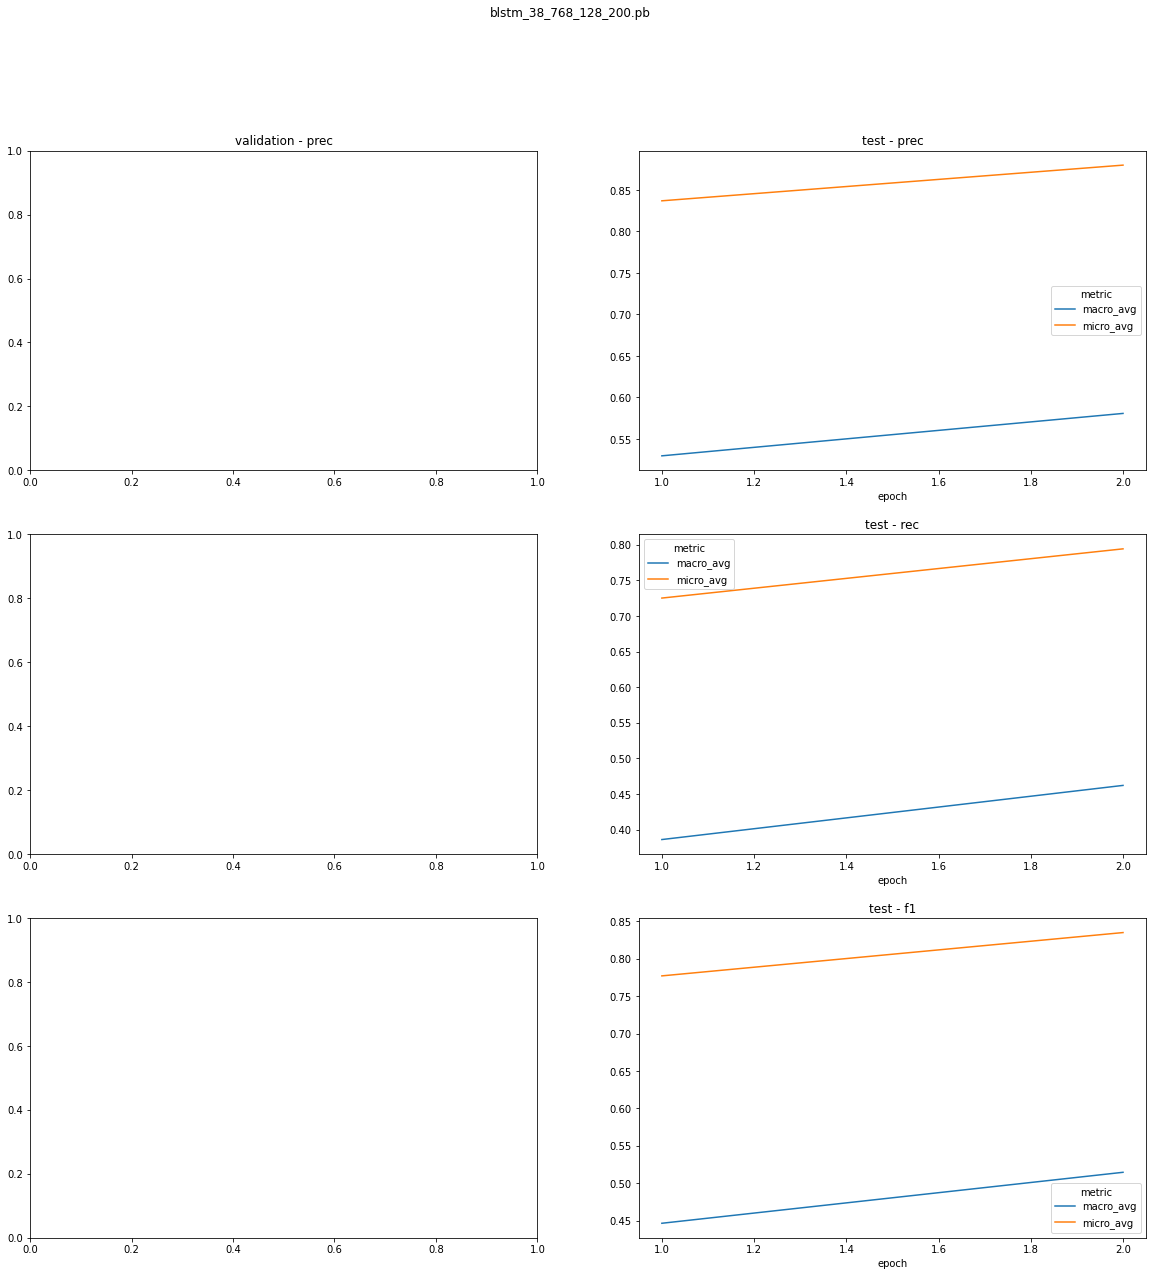

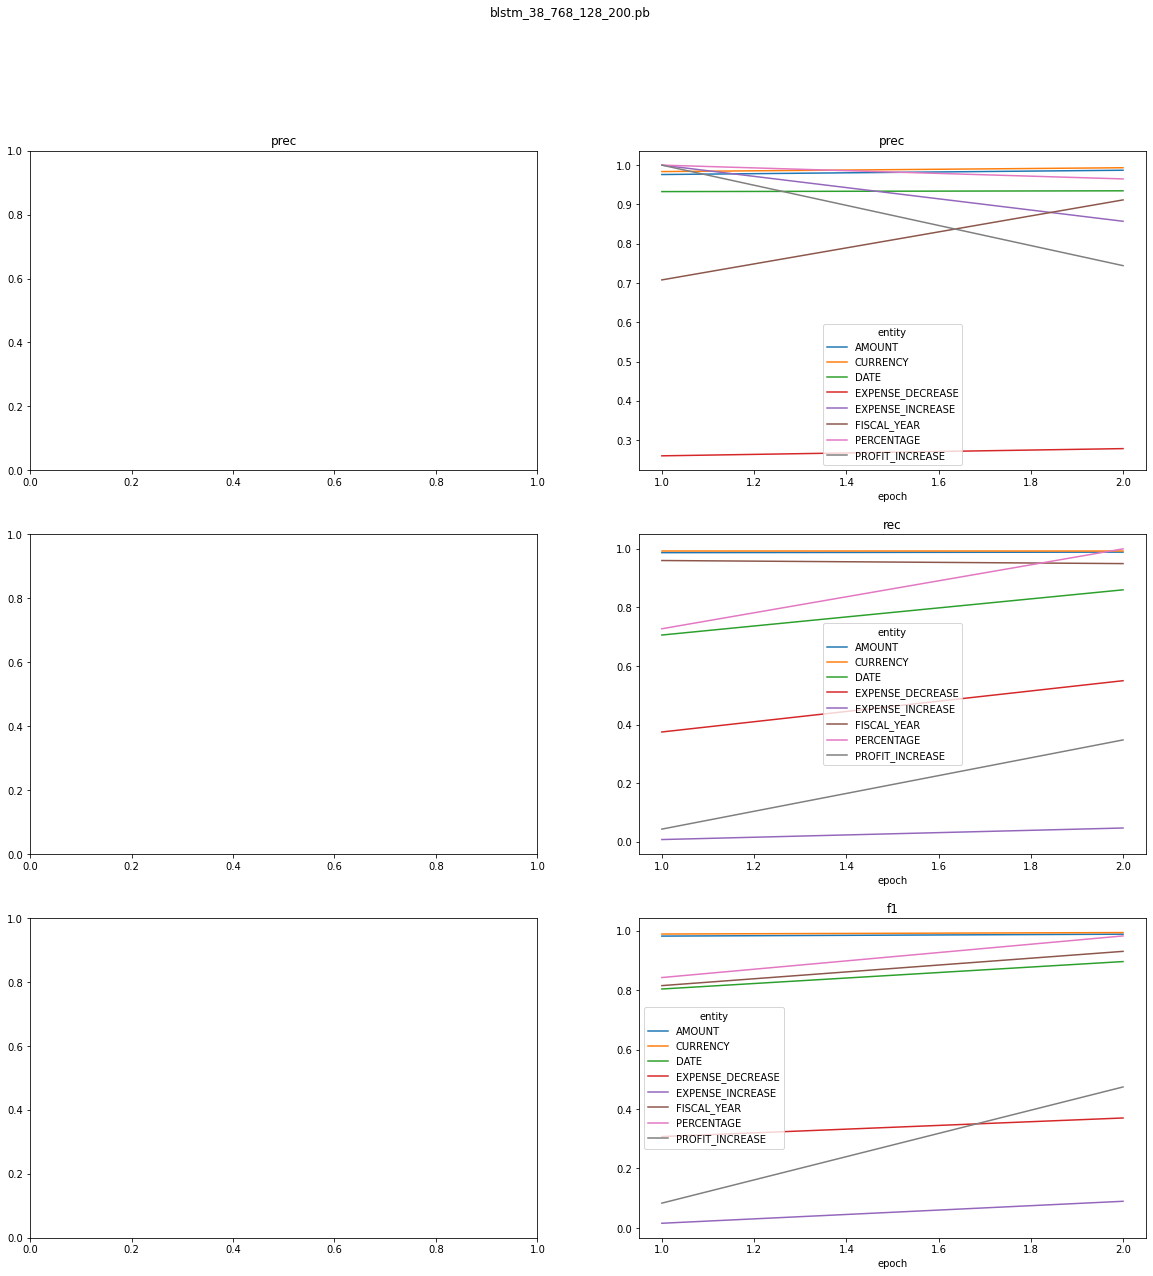

In [ ]:
import ner_log_parser

%matplotlib inline

ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

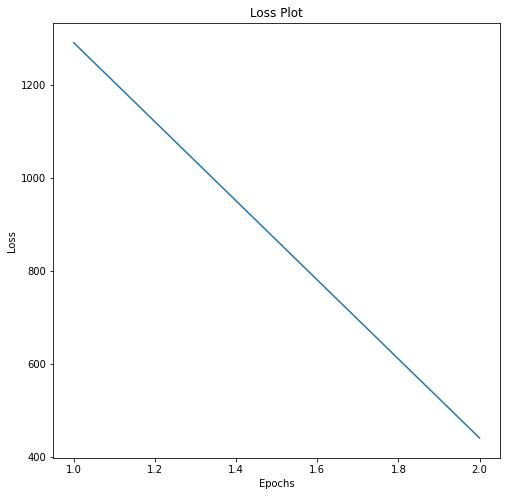

In [ ]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

###💾 Saving the trained model

In [ ]:
ner_model.stages

Out[43]: [BERT_EMBEDDINGS_29ce72cd673e, FinanceNerModel_315749b23a90]

In [ ]:
ner_model.stages[1].write().overwrite().save('dbfs:/databricks/driver/models/NER_bert_e2_b32')

###✔️ Prediction Pipeline

In [ ]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

text_splitter = finance.TextSplitter()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = nlp.Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = finance.NerModel.load("dbfs:/databricks/driver/models/NER_bert_e2_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = finance.NerConverterInternal()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = nlp.Pipeline(
    stages = [
        document,
        text_splitter,
        token,
        bert_embeddings,
        loaded_ner_model,
        converter
    ])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[ | ][OK!]

In [ ]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [ ]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
text |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base .|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [ ]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+-----------+--------+
chunk |entity |
+-----------+--------+
$ |CURRENCY|
4.2 million|AMOUNT |
+-----------+--------+

In [ ]:
light_model = nlp.LightPipeline(prediction_model)

In [ ]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

Out[50]: [('$', 'B-CURRENCY'),
 ('4.2', 'B-AMOUNT'),
 ('million', 'I-AMOUNT'),
 ('of', 'O'),
 ('the', 'O'),
 ('increase', 'O'),
 ('was', 'O'),
 ('compensation', 'O'),
 ('related', 'O'),
 ('and', 'O'),
 ('primarily', 'O'),
 ('attributable', 'O'),
 ('to', 'O'),
 ('an', 'O'),
 ('increase', 'O'),
 ('in', 'O'),
 ('headcount', 'O'),
 ('to', 'O'),
 ('support', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('growth', 'O'),
 ('of', 'O'),
 ('our', 'O'),
 ('subscription', 'O'),
 ('SaaS', 'O'),
 ('offerings', 'O'),
 ('and', 'O'),
 ('ongoing', 'O'),
 ('maintenance', 'O'),
 ('and', 'O'),
 ('support', 'O'),
 ('for', 'O'),
 ('our', 'O'),
 ('expanding', 'O'),
 ('customer', 'O'),
 ('base', 'O'),
 ('.', 'O')]

In [ ]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[51]:

,sent_id,token,start,end,ner
0,0,$,0,0,B-CURRENCY
1,0,4.2,2,4,B-AMOUNT
2,0,million,6,12,I-AMOUNT
3,0,of,14,15,O
4,0,the,17,19,O
5,0,increase,21,28,O
6,0,was,30,32,O
7,0,compensation,34,45,O
8,0,related,47,53,O
9,0,and,55,57,O


###🏉  Highlight Entities

In [ ]:
result = result[0]
visualiser = nlp.viz.NerVisualizer()
displayHTML(visualiser.display(result, label_col='ner_span', document_col='document', return_html = True))

$ CURRENCY 4.2 million AMOUNT of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base .